## Engineering Notebook

---

In this notebook, we analyze the extracted features, assessing the necessity of normalization. We also investigate possible feature selection techniques to reduce the dimensionality of the data.
The sections are organized as follows:

1. [Load Data](#Load-Data)
2. [Feature Analysis](#2.-Feature-Analysis)
    1. [Visualize Features](#2.1.-Visualize-Features)
    2. [Feature correlation](#2.2.-Feature-Correlation)
3. [Covariance analysis](#3-covariance-matrix-of-the-groups)
4. [Feature Selection](#4.-Feature-Selection)
5. [Outliers Detection](#5.-Outliers-Detection)
6. [Feature distribution](#6-Feature-Distribution)
7. [PCA](#7-PCA)
8. [Save the data](#8-Save-Data)



In [40]:
# import all the functions
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys
from scipy.stats import spearmanr
import seaborn as sns

sys.path.append("../")
import pandas as pd
from sklearn.cluster import KMeans

In [41]:
# paths to the features and the labels
FOLDER = "../../features/balanced/both/"
FILE_PATH = (
    FOLDER
    + "full_data_both_bal_2s_4000hz_30mfcc_12chroma_70cqt_41rms_41zcr_41sc_61sb_41sr.npy"
)

THRESH_1 = 0
THRESH_2=0.6
N_FEATURES_CORR=30
feature_names = (
    [f"MFCC {i}" for i in range(1, 31)]
    + [f"Chroma {i}" for i in range(1, 13)]
    + [f"CQT {i}" for i in range(1, 71)]
    + [f"RMS {i}" for i in range(1, 42)]
    + [f"ZCR {i}" for i in range(1, 42)]
    + [f"SC {i}" for i in range(1, 42)]
    + [f"SB {i}" for i in range(1, 62)]
    + [f"SR {i}" for i in range(1, 42)]
)

In [42]:
def remove_features(data, data_df, features_to_drop, file_path):
    # Drop the identified features from the dataset
    indexes = data_df.columns.get_indexer(features_to_drop)
    print("Removing features from the dataset")
    filtered_data = data
    # Check if the file path indicates posterior or both types of data
    if ("posterior" in file_path) or ("both" in file_path):
        # Load the data from the file and extract the "train_bal" subset
        for key in filtered_data.keys():
            filtered_data[key]["X"] = np.delete(
                filtered_data[key]["X"], indexes, axis=1
            )
            print(filtered_data[key]["X"].shape)
    else:
        # Iterate over each name in names
        for name in names:
            # Load the data from the file and extract the subset for the current name
            filtered_data[name]["X"] = np.delete(
                filtered_data[name]["X"], indexes, axis=1
            )
    return filtered_data


def remove_highly_correlated_features(
    correlation_matrix_comp: pd.DataFrame,
    correlation_matrix_no_target: pd.DataFrame,
    target_variable: str = "label",
    threshold: float = 0.7,
    max_corr_count: int = 4,
) -> list:
    """
    Remove highly correlated features based on correlation matrix.

    Parameters:
        correlation_matrix_comp (pd.DataFrame): Complete correlation matrix including the target variable.
        correlation_matrix_no_target (pd.DataFrame): Correlation matrix without the target variable.
        target_variable (str): The name of the target variable.
        threshold (float): Threshold above which features are considered highly correlated.
        max_corr_count (int): Maximum number of highly correlated features to keep.

    Returns:
        List[str]: List of features to remove.
    """
    features_to_remove = set()

    # Iterate through each feature
    for feature in correlation_matrix_no_target.columns:
        # Count the number of features with correlation higher than threshold
        correlated_count = (correlation_matrix_no_target[feature] > threshold).sum()
        # If the count is greater than the maximum allowed count
        if correlated_count > max_corr_count:
            # Get the correlations of the highly correlated features with the target variable
            target_correlations = correlation_matrix_no_target.loc[feature]
            candidates = target_correlations[target_correlations > threshold].index
            best = (
                correlation_matrix_comp.loc[candidates, target_variable].abs().idxmax()
            )
            features_to_remove.update(candidates.difference([best]))

    # Remove the highly correlated features
    print(f" {len(features_to_remove)} features should be removed")
    return list(features_to_remove)


def read_file(file_path: str, feature_names: list):

    dataset = []  # Initialize an empty list to store dataset
    data = None  # Initialize data to None

    # Check if the file path indicates posterior or both types of data
    if ("posterior" in file_path) or ("both" in file_path):
        # Load the data from the file and extract the "train_bal" subset
        data = np.load(file_path, allow_pickle=True).item()
        datam = data["train"]

        # Separate features (X) and labels (y), then concatenate them into one array
        X = datam["X"]
        y = datam["y"].reshape(-1, 1)
        dataset = np.concatenate((X, y), axis=1)
    else:
        # Initialize a list to store data from multiple names
        data_list = []
        data = np.load(file_path, allow_pickle=True).item()

        # Iterate over each name in names
        for name in names:
            datam = data[name]

            # Separate features (X) and labels (y), then concatenate them into one array
            X = datam["X"]
            y = datam["y"].reshape(-1, 1)
            data_combined = np.concatenate((X, y), axis=1)
            data_list.append(data_combined)  # Add the combined data to the list

        # Concatenate all data from the list into one dataset
        dataset = np.concatenate(data_list, axis=0)

    # Convert the dataset into a pandas DataFrame with feature names and label
    data_df = pd.DataFrame(dataset, columns=feature_names + ["label"])

    return data, data_df

data, data_df = read_file(FILE_PATH, feature_names)

### 2. Feature Analysis


#### 2.1. Visualize Features


In [43]:
data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MFCC 1,4920.0,-329.061940,178.383897,-1131.369507,-431.704895,-275.312469,-220.320496,167.189133
MFCC 2,4920.0,59.600846,57.661523,-78.712997,0.522146,72.243340,106.554756,192.349472
MFCC 3,4920.0,0.658035,27.752296,-127.370308,-14.589432,1.709415,15.509132,111.182259
MFCC 4,4920.0,7.008997,24.475992,-93.446770,-4.497349,8.483062,24.745527,81.181580
MFCC 5,4920.0,-12.095979,15.949005,-78.356270,-23.147789,-11.637479,-0.467634,75.286575
...,...,...,...,...,...,...,...,...
SR 38,4920.0,744.502033,509.883886,0.000000,320.000000,580.000000,1120.000000,1910.000000
SR 39,4920.0,732.806911,510.667210,0.000000,300.000000,560.000000,1090.000000,1910.000000
SR 40,4920.0,736.967480,504.200037,0.000000,310.000000,590.000000,1092.500000,1900.000000
SR 41,4920.0,831.032520,455.151971,0.000000,470.000000,740.000000,1142.500000,1900.000000


#### 2.2. Feature Correlation


#### Test Normalità


In [44]:
import scipy.stats as stats

p_values = []
test_val = []

# Calcola il test di normalità per ciascuna colonna del dataframe
for column in data_df.columns:
    test = stats.normaltest(data_df[column])
    p_values.append(test[1])
    test_val.append(test[0])

# Crea un dataframe contenente i risultati del test di normalità
norm_df = pd.DataFrame(
    {"Feature": data_df.columns, "D'Agostino-Pearson": test_val, "P-value": p_values}
)

norm_df.set_index("Feature", inplace=True)


# Definisci una funzione per colorare le celle in base al p-value
def color_cells(val):
    color = (
        "green" if val >= 0.05 else "red"
    )  # Assumendo un livello di significatività del 0.05
    if val > 1:
        color = None
    return "background-color: %s" % color


# Applica la funzione di colorazione al DataFrame
styled_norm_df = norm_df.style.applymap(color_cells)

styled_norm_df

/tmp/ipykernel_12679/3873497847.py:31: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_norm_df = norm_df.style.applymap(color_cells)


,D'Agostino-Pearson,P-value
Feature,,
MFCC 1,1186.913653,0.000000
MFCC 2,2525.418584,0.000000
MFCC 3,349.636851,0.000000
MFCC 4,376.479996,0.000000
MFCC 5,93.920630,0.000000
MFCC 6,376.292020,0.000000
MFCC 7,445.023750,0.000000
MFCC 8,192.729051,0.000000
MFCC 9,926.827256,0.000000


#### Compute the correlation coefficient between the features and the target variable.


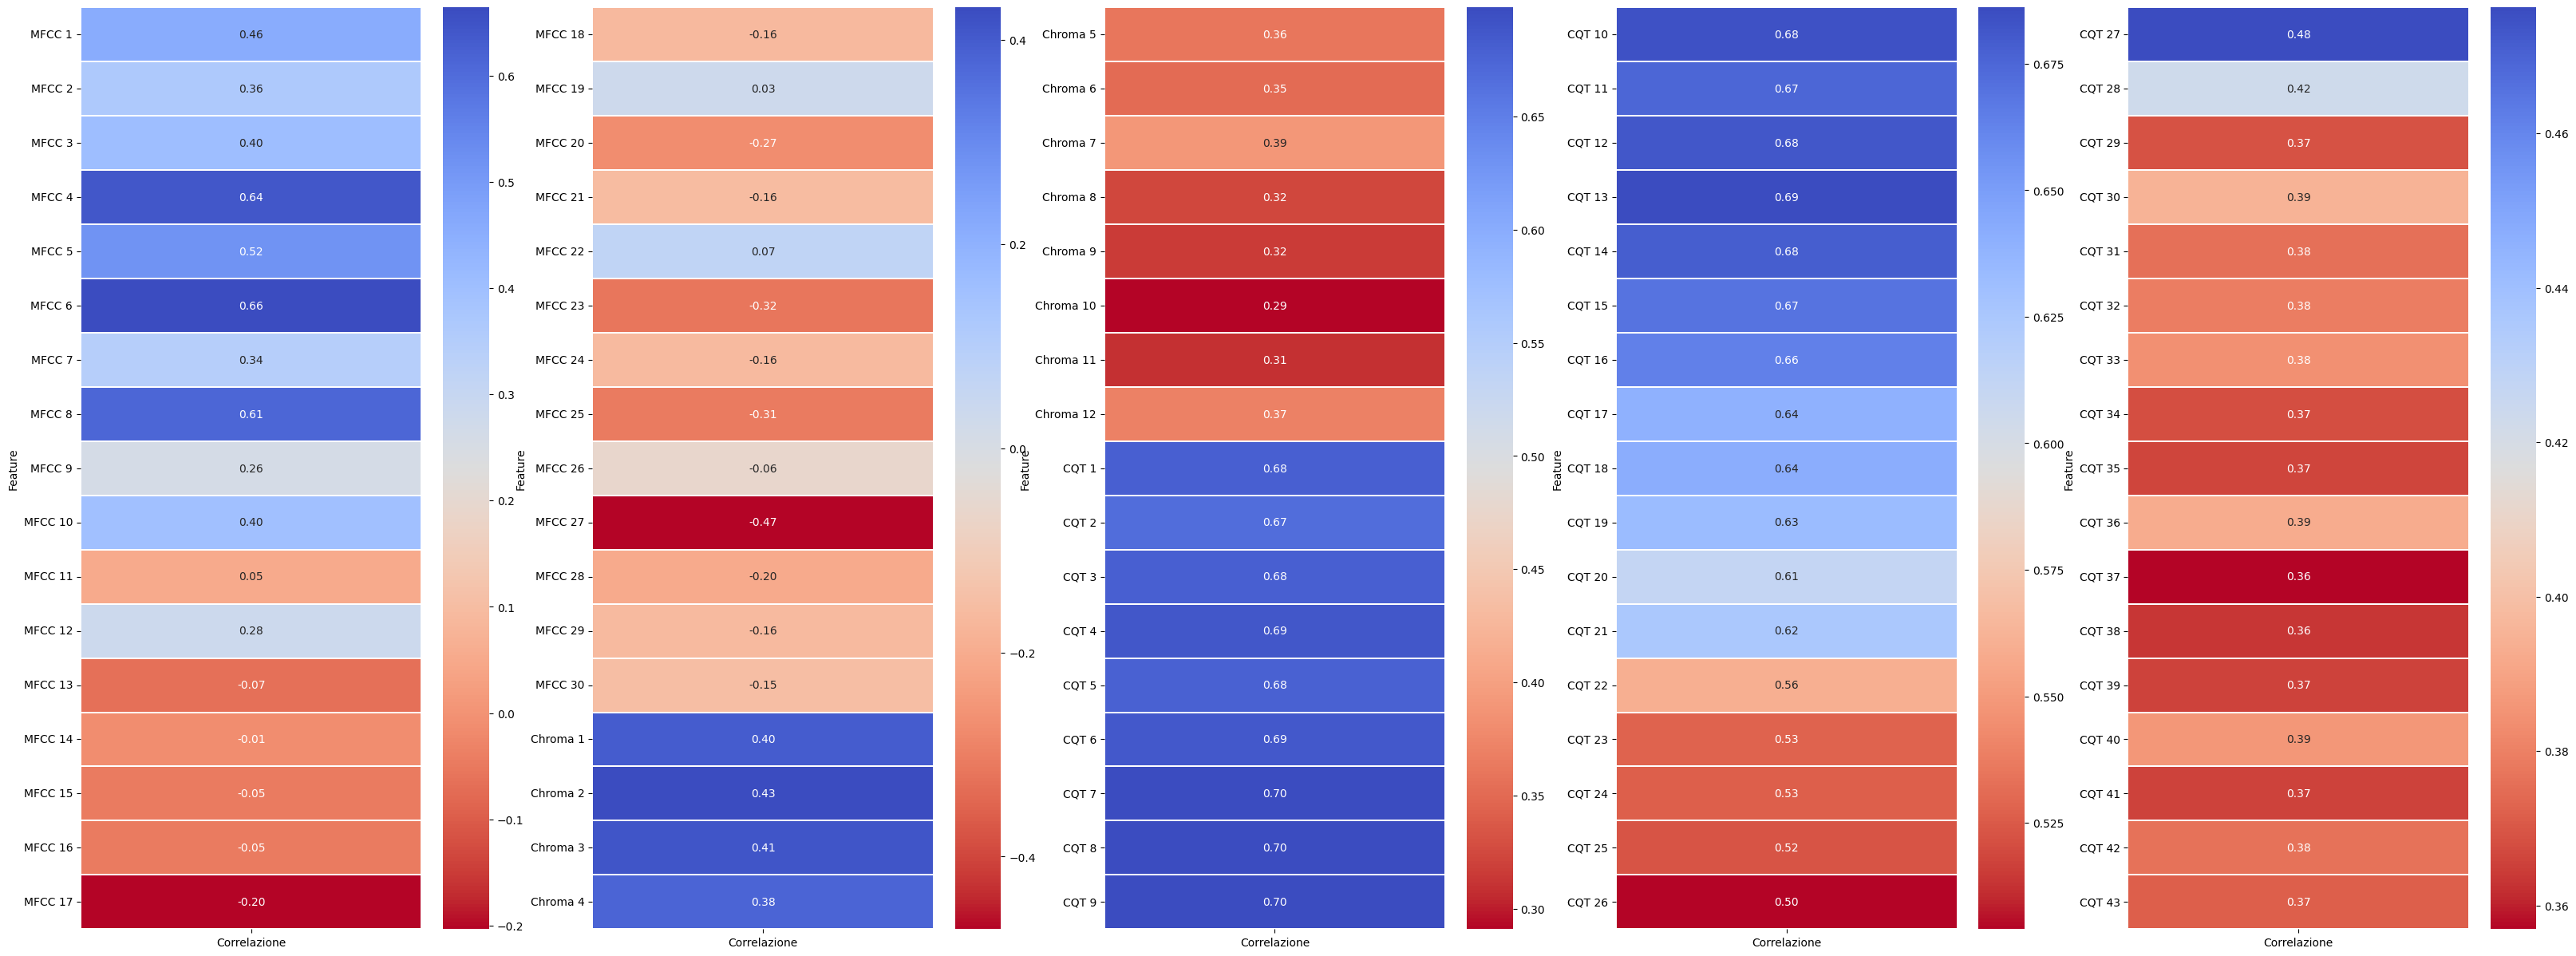

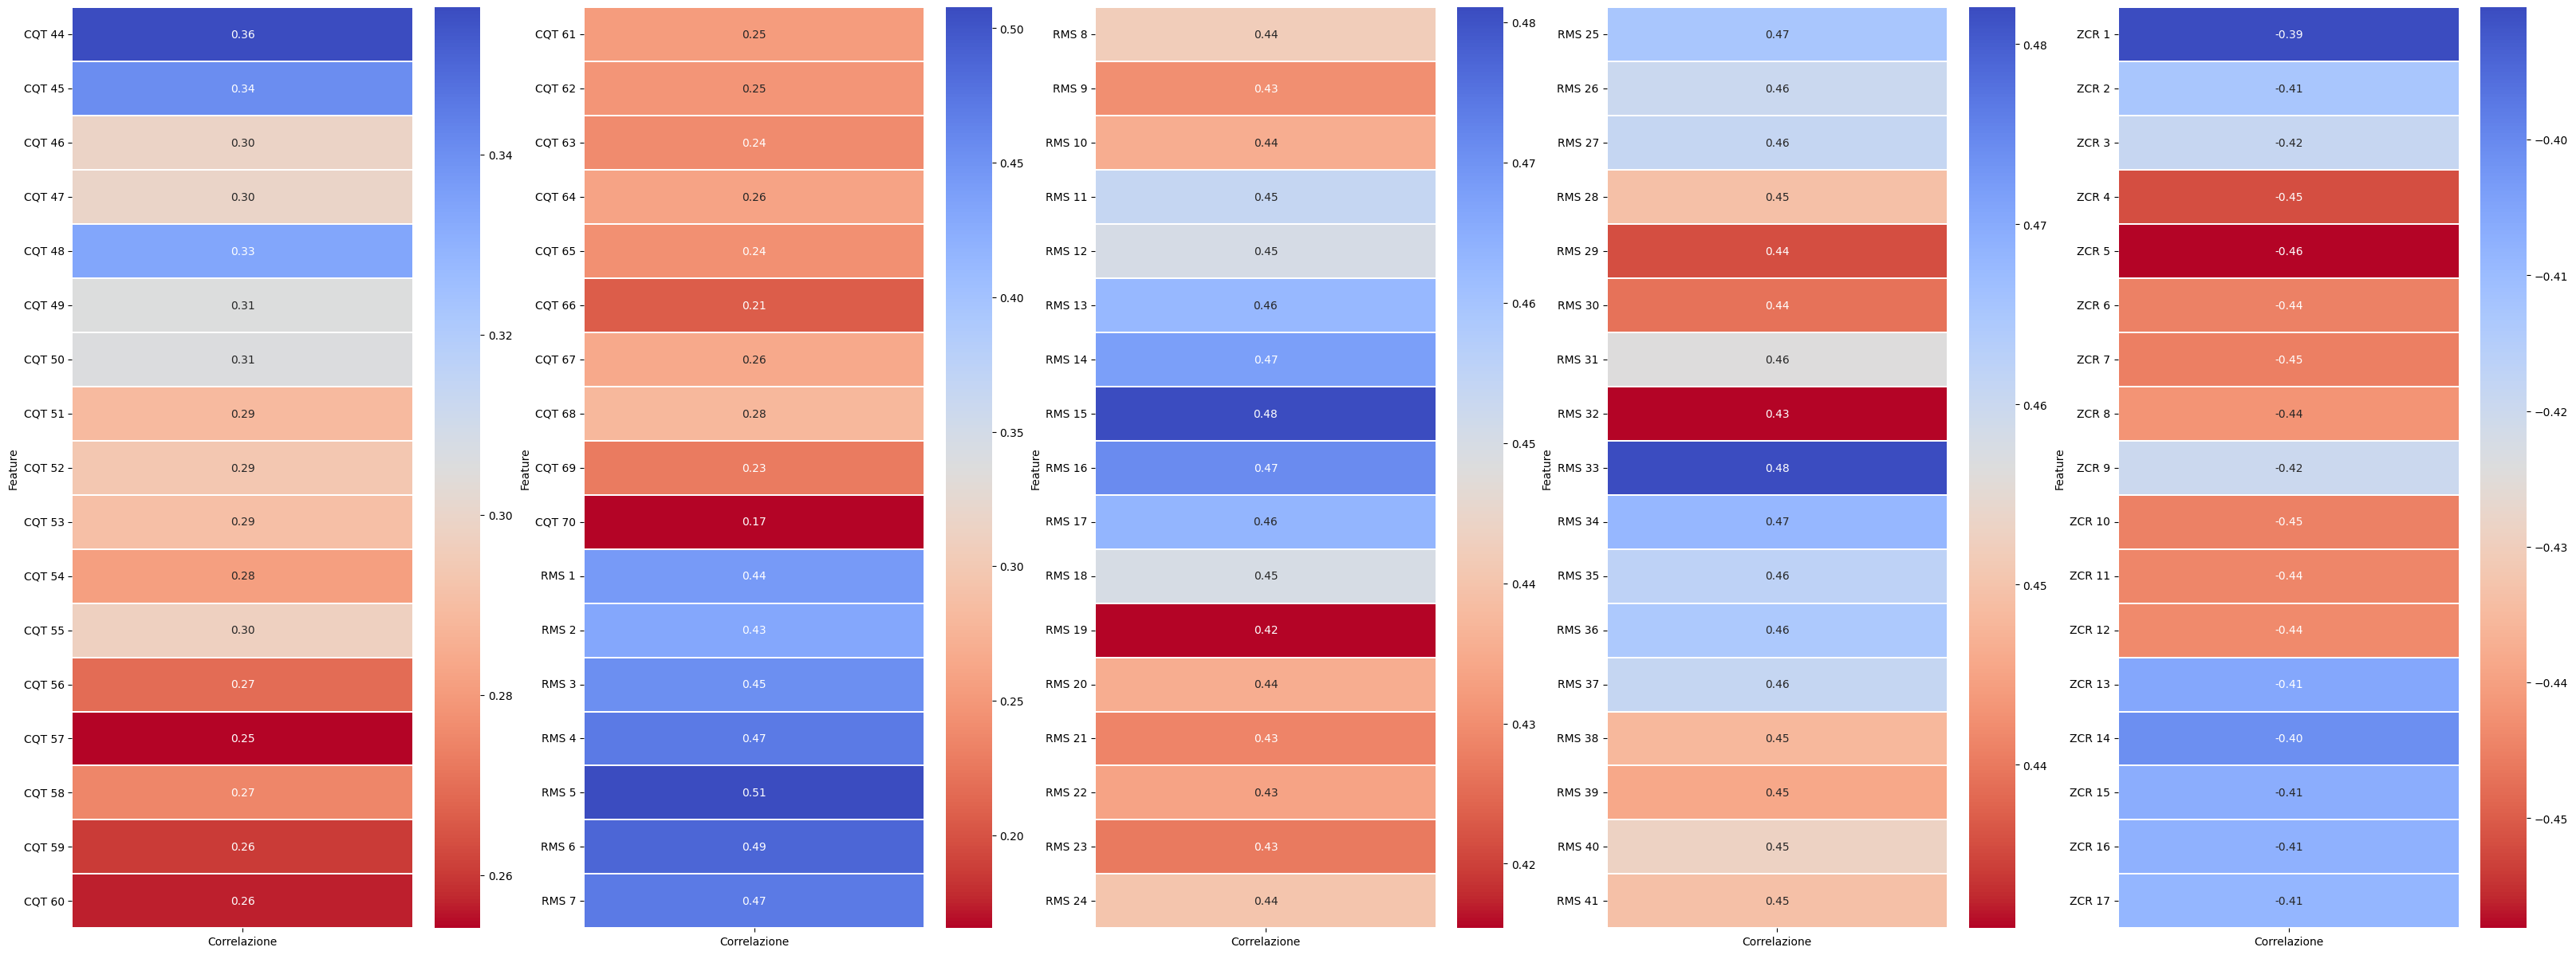

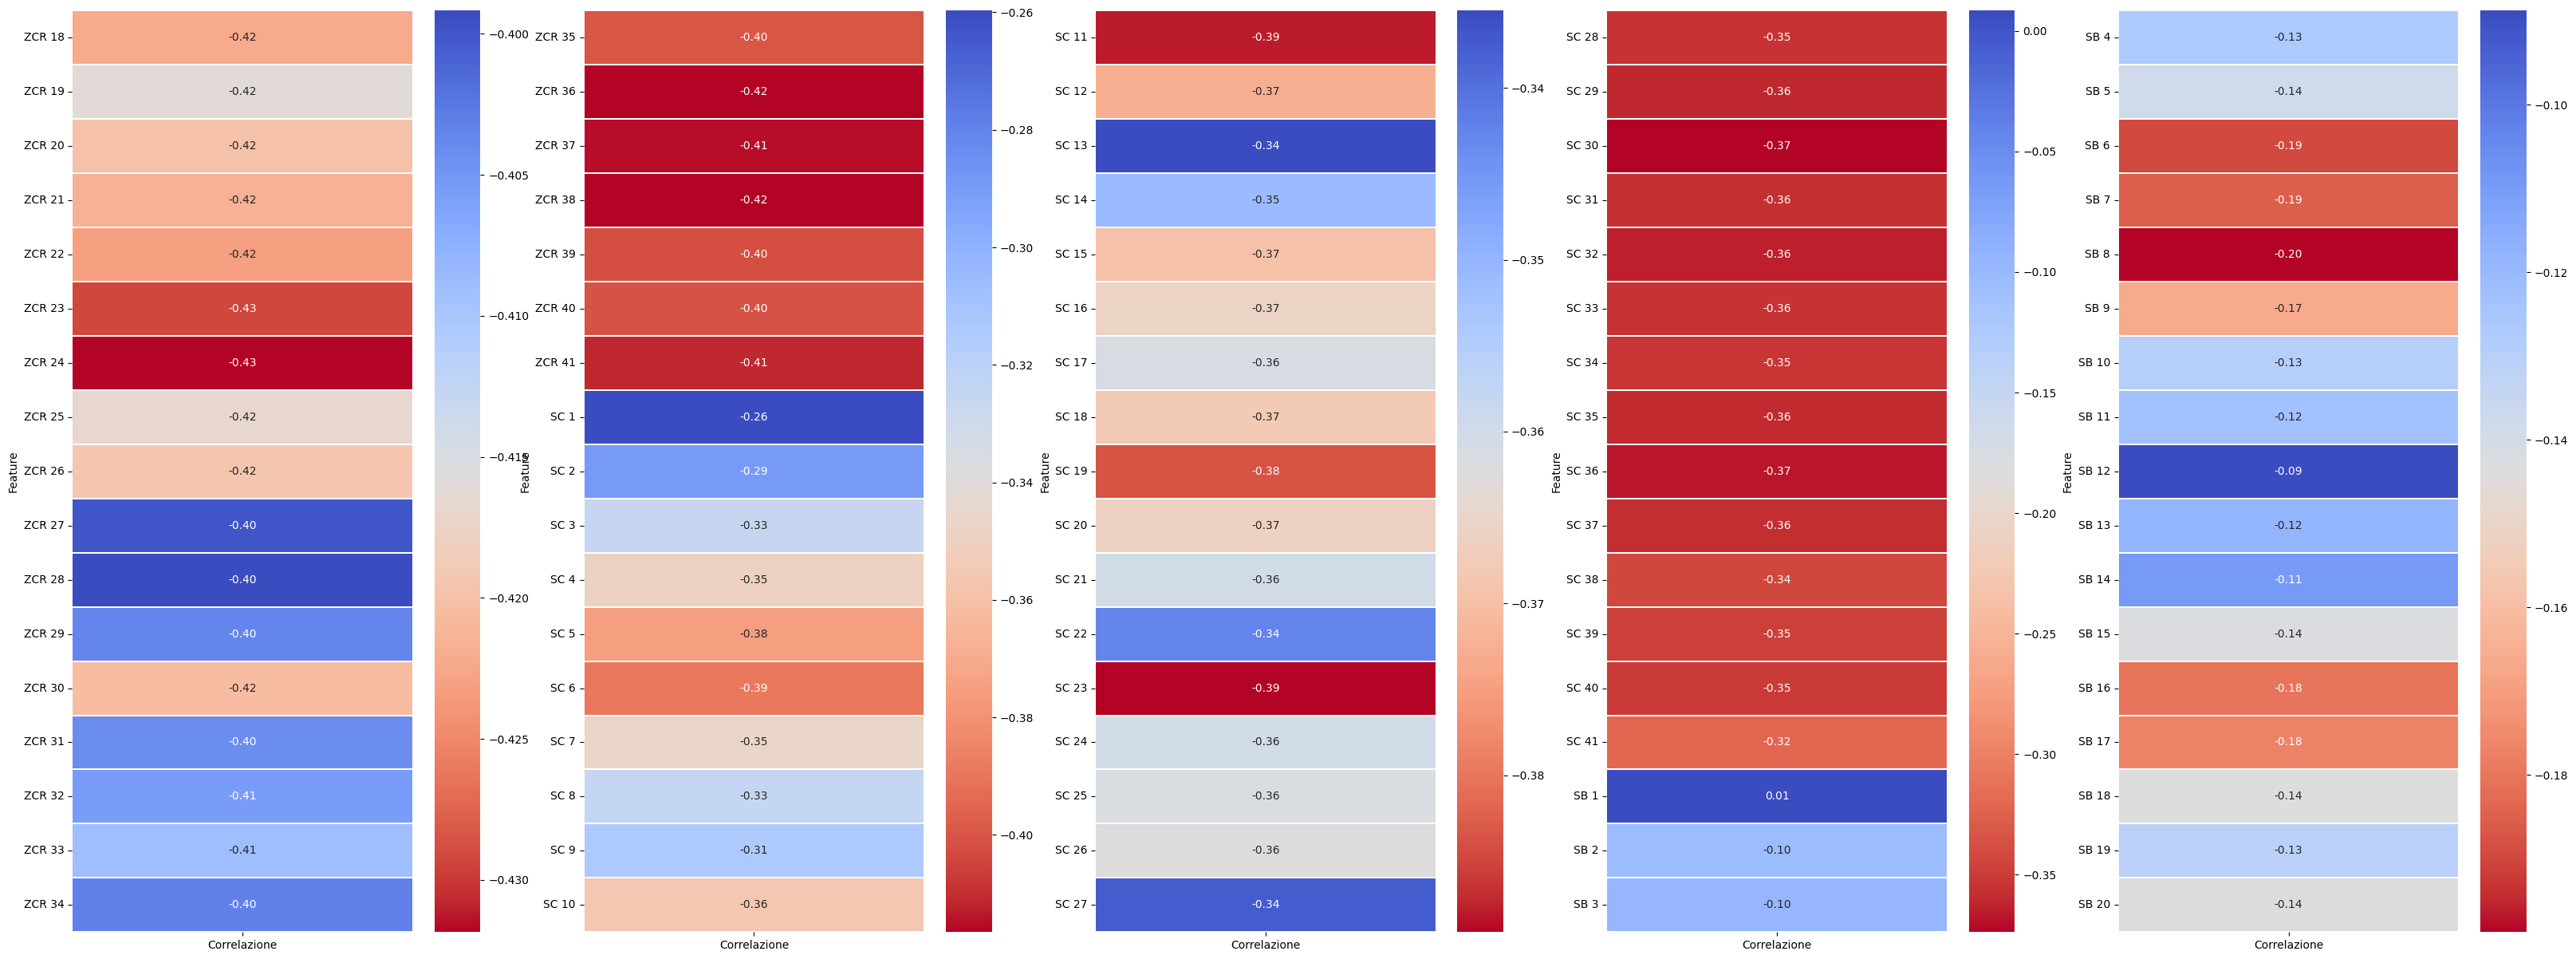

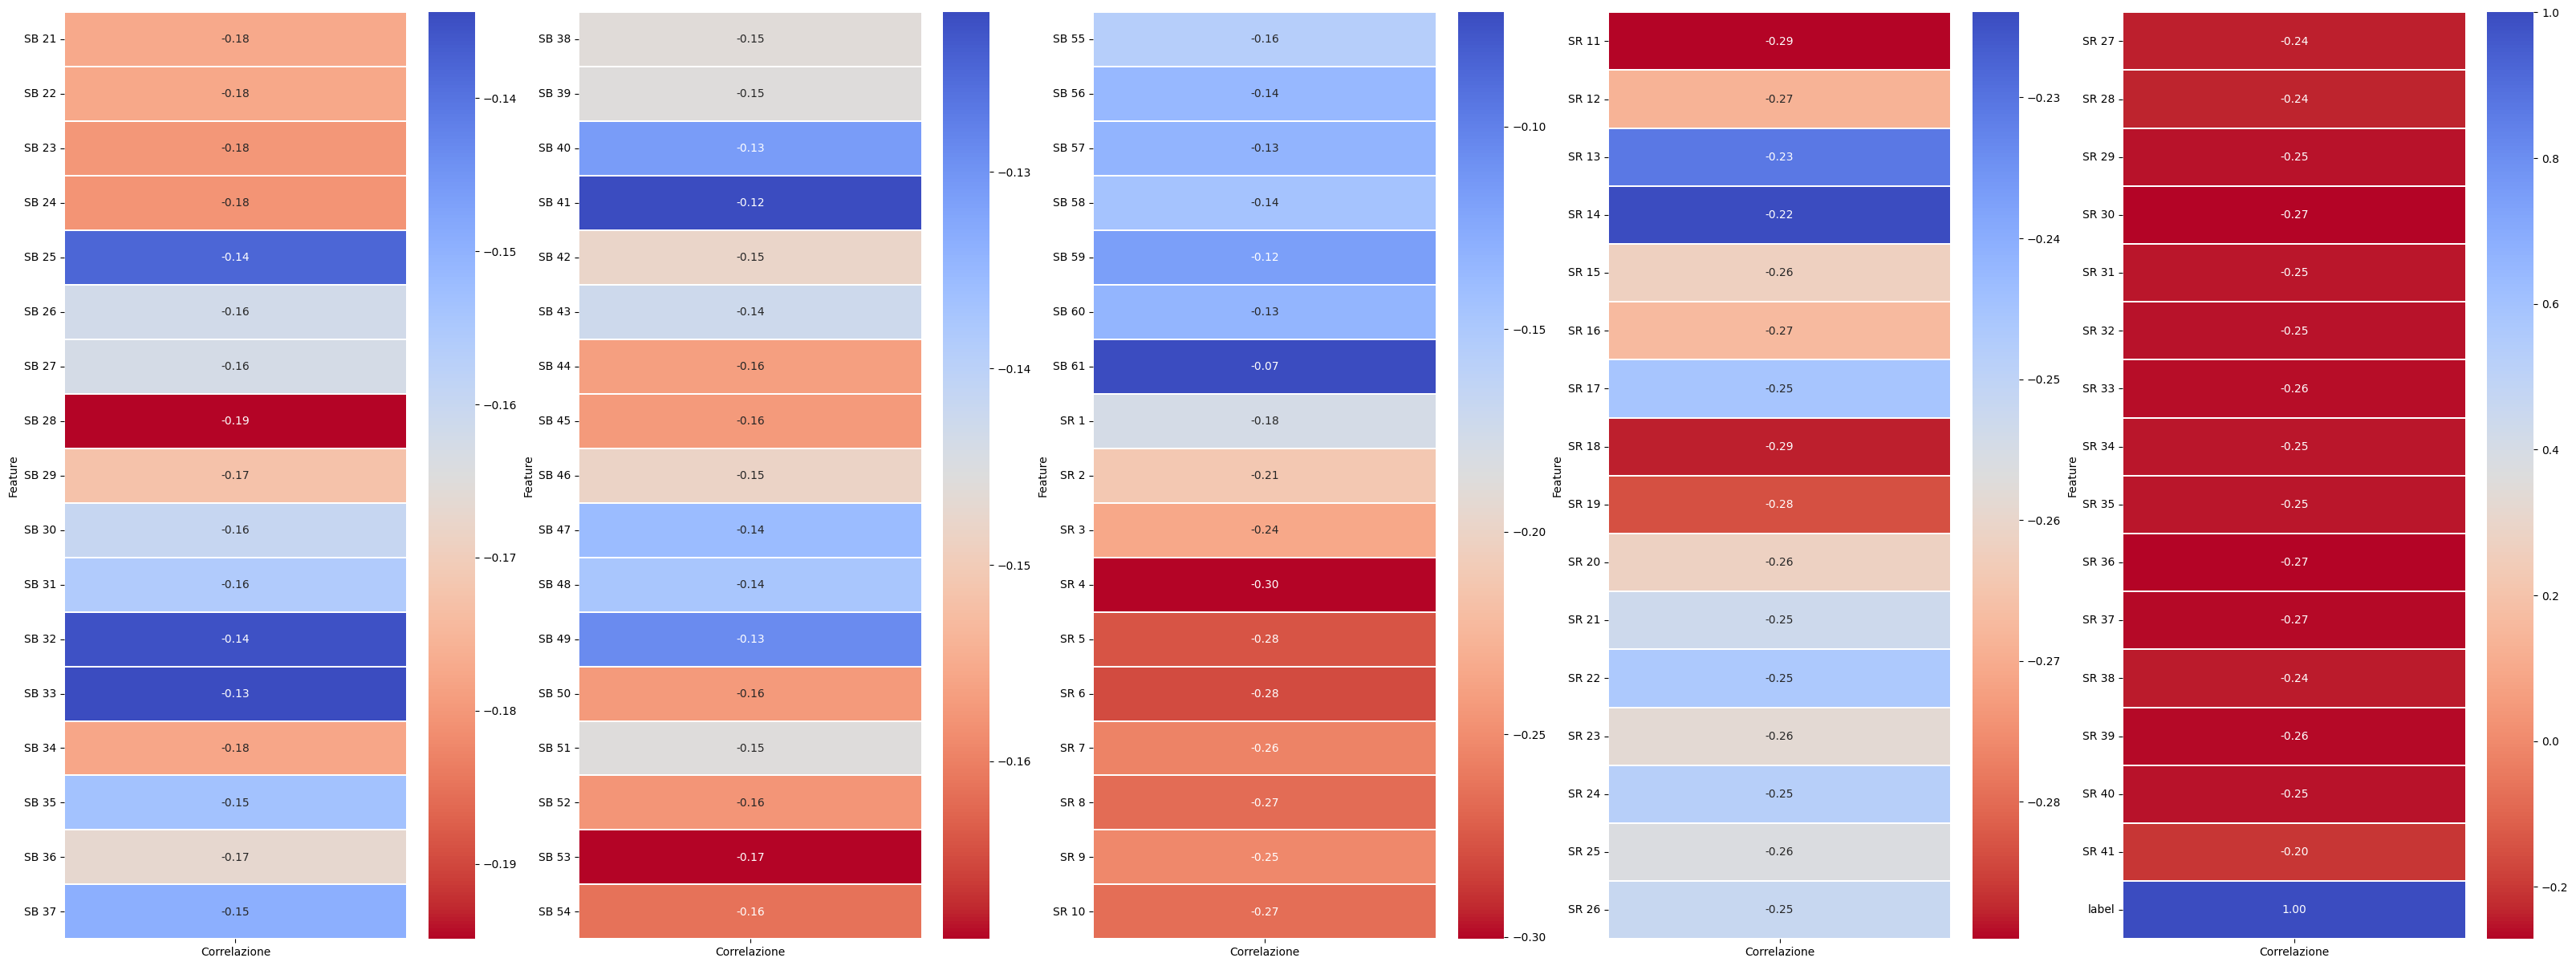

In [45]:
columns = data_df.columns
# Importa le librerie necessarie

groups = np.array_split(columns, 20)
corr_5 = []
feature_5=[]
for group in groups:
    correlazione = []
    features = []
    for col1 in group:
        correlation, p_value = spearmanr(data_df[col1], data_df["label"])
        correlazione.append(correlation)
        features.append(col1)
    corr_5.append(correlazione)
    feature_5.append(features)

    if len(corr_5) == 5:
        fig, axes = plt.subplots(1, 5, figsize=(40, 15))  # Creating a 5x5 subplot grid
        for i, ax in enumerate(axes.flat):
            correlazione_df = pd.DataFrame(
                {"Feature": feature_5[i], "Correlazione": corr_5[i]}
            )
            correlazione_df.set_index("Feature", inplace=True)
            sns.heatmap(correlazione_df, annot=True, fmt=".2f", cmap="coolwarm_r",linewidths=0.1, ax=ax, cbar=True,)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        plt.show()
        corr_5 = []
        feature_5 = []


In [46]:
# Importa le librerie necessarie
p_values = []
correlazione = []
features = []
# Calcola i coefficienti di correlazione di Kendall e i valori p per ogni coppia di colonne nel dataframe
for col1 in data_df.columns:
    correlation, p_value = spearmanr(data_df[col1], data_df["label"])
    p_values.append(p_value)
    correlazione.append(correlation)
    features.append(col1)

correlazione_df = pd.DataFrame(
    {"Feature": features, "Correlazione": correlazione, "P-value": p_values}
)

correlazione_df.set_index("Feature", inplace=True)


Remove features with low correlation with the target variable.

In [47]:
features_slightly_corr = correlazione_df[np.abs(correlazione_df["Correlazione"]) <=THRESH_1].index
print(len(features_slightly_corr))


0


In [48]:
print(len(data_df.columns))
print(data_df.columns)

338
Index(['MFCC 1', 'MFCC 2', 'MFCC 3', 'MFCC 4', 'MFCC 5', 'MFCC 6', 'MFCC 7',
       'MFCC 8', 'MFCC 9', 'MFCC 10',
       ...
       'SR 33', 'SR 34', 'SR 35', 'SR 36', 'SR 37', 'SR 38', 'SR 39', 'SR 40',
       'SR 41', 'label'],
      dtype='object', length=338)


### 4 Feature Selection
Remove the features that are highly correlated with each other.
Like 'Spectral centroid' and 'Spectral bandwidth' and 'Spectral rolloff'

In [49]:

correlation_matrix = data_df.corr(method="spearman")
correlation_matrix_no_target = data_df.drop(columns=["label"]).corr(method="spearman")
highly_corr_each = remove_highly_correlated_features(
    correlation_matrix, correlation_matrix_no_target, threshold=THRESH_2, max_corr_count=N_FEATURES_CORR
)


 298 features should be removed


### 8. Save Data

In [50]:
remove1 = set(features_slightly_corr)
remove2 = set(highly_corr_each)
features_to_drop = remove1.union(remove2)
print(len(features_to_drop))
filtered_data = remove_features(data, data_df, features_to_drop, FILE_PATH)

filtered_df = data_df.drop(columns=features_to_drop)
feat_names = ["MFCC", "Chroma", "CQT", "RMS", "ZCR", "SC", "SB", "SR"]
feat_count = []
filename = "full_data_filtered_2s_4000hz_"
for name in feat_names:
    feat_count.append(len([col for col in filtered_df.columns if name in col]))
    filename=filename+str(feat_count[-1])+str.lower(name)+"_"
    print(f"{name}: {feat_count[-1]}")
filename=filename+".npy"

features = filtered_df.drop(columns="label").columns


filtered_data["features"] = features
print("Saving filtered data")
# Construct the full file path for the current feature file
save_file_path = os.path.join(
    FOLDER,
    filename,
)
np.save(save_file_path, filtered_data)

298
Removing features from the dataset
(4920, 39)
(568, 39)
MFCC: 25
Chroma: 12
CQT: 1
RMS: 0
ZCR: 1
SC: 0
SB: 0
SR: 0
Saving filtered data
